In [1]:
import os
import json
import hydra
import numpy as np
import enreg.tools.general as g
import mplhep as hep
import awkward as ak
import matplotlib.pyplot as plt
from omegaconf import DictConfig

In [2]:
hep.style.use(hep.styles.CMS)

In [3]:
c = 299792458000  # mm/s
tau_lifetime = 2.903e-13  # s
tau_mass = 1.77  # GeV

In [4]:
def plot(values, title, output_path, xmin, xmax, print_rms=True, nbins=30):
    fig, ax = plt.subplots()
    rms = np.sqrt(ak.sum(values**2) * (1 / (len(values))))
    bins = np.linspace(xmin, xmax, num=30)
    hist, bin_edges = np.histogram(values, bins=bins)
    hist = hist / ak.sum(hist)
    hep.histplot(hist, bin_edges)
    plt.xlabel("mm", loc="center")
    plt.title(title)
    if print_rms:
        textstr = f"RMS={'{:0.3e}'.format(rms)}"
        props = {"boxstyle": "round", "facecolor": "white", "alpha": 0.5}
        ax.text(0.6, 0.8, textstr, transform=ax.transAxes, fontsize=16, verticalalignment="top", bbox=props)
    plt.xlim((xmin, xmax))
    plt.savefig(output_path)
    plt.close("all")

In [5]:
def process_data(data, output_dir):
    tau_mask = data["gen_jet_tau_decaymode"] > 0
    data = data[tau_mask]
    gen_jet_tau_p4s = g.reinitialize_p4(data["gen_jet_full_tau_p4s"])
    gen_jet_tau_gamma = np.sqrt(1 + (gen_jet_tau_p4s.p / tau_mass) ** 2)
    # gen_jet_tau_gamma = 1 / np.sqrt(1 - (gen_jet_tau_p4s.p / tau_mass) ** 2)
    expected_traveldistance = gen_jet_tau_gamma * c * tau_lifetime
    track_mask = abs(data["reco_cand_charge"]) > 0
    # tau_descendant_mask = data["reco_cand_matched_gen_energy"] / g.reinitialize_p4(data["reco_cand_p4s"]).energy > 0.1
    suitable_cands_mask = track_mask
    # gen jet distance from the decay vertex
    gen_DV_dist = (
        np.sqrt(
            (data["gen_jet_tau_decay_vertex_x"]-data["reco_cand_PV_x"]) ** 2
            + (data["gen_jet_tau_decay_vertex_y"]-data["reco_cand_PV_y"]) ** 2
            + (data["gen_jet_tau_decay_vertex_z"]-data["reco_cand_PV_z"]) ** 2
        )
        / expected_traveldistance
    )
    gen_DV_dist_ = np.sqrt(
        (data["gen_jet_tau_decay_vertex_x"]-data["reco_cand_PV_x"]) ** 2
        + (data["gen_jet_tau_decay_vertex_y"]-data["reco_cand_PV_y"]) ** 2
        + (data["gen_jet_tau_decay_vertex_z"]-data["reco_cand_PV_z"]) ** 2
    )
    gen_lifetime = gen_DV_dist_ / (gen_jet_tau_gamma * c)

    gen_jet_tau_pt = g.reinitialize_p4(data["gen_jet_full_tau_p4s"]).pt
    
    # reco tau distance from reco primary vertex ?
    reco_pca_dist_from_reco_PV = np.sqrt(
        (data["reco_cand_PV_x"][suitable_cands_mask] - data["reco_cand_PCA_x"][suitable_cands_mask]) ** 2
        + (data["reco_cand_PV_y"][suitable_cands_mask] - data["reco_cand_PCA_y"][suitable_cands_mask]) ** 2
        + (data["reco_cand_PV_z"][suitable_cands_mask] - data["reco_cand_PCA_z"][suitable_cands_mask]) ** 2
    )
    # Reco PV distance from gen PV
    reco_PV_from_gen_PV = np.sqrt(
        data["reco_cand_PV_x"][suitable_cands_mask] ** 2
        + data["reco_cand_PV_y"][suitable_cands_mask] ** 2
        + data["reco_cand_PV_z"][suitable_cands_mask] ** 2
    )
    # ?
    reshaped_gen_DV_x = ak.ones_like((data["reco_cand_PCA_x"][suitable_cands_mask])) * data["gen_jet_tau_decay_vertex_x"]
    reshaped_gen_DV_y = ak.ones_like((data["reco_cand_PCA_y"][suitable_cands_mask])) * data["gen_jet_tau_decay_vertex_y"]
    reshaped_gen_DV_z = ak.ones_like((data["reco_cand_PCA_z"][suitable_cands_mask])) * data["gen_jet_tau_decay_vertex_z"]
    reco_PCA_from_gen_DV = np.sqrt(
        (data["reco_cand_PCA_x"][suitable_cands_mask] - reshaped_gen_DV_x) ** 2
        + (data["reco_cand_PCA_y"][suitable_cands_mask] - reshaped_gen_DV_y) ** 2
        + (data["reco_cand_PCA_z"][suitable_cands_mask] - reshaped_gen_DV_z) ** 2
    )
    reco_cand_pt = g.reinitialize_p4(data["reco_cand_p4s"][suitable_cands_mask]).pt
    high_pt_mask = reco_cand_pt > 20
    
    #Plottins starts here
    plot(
        values=ak.flatten(gen_jet_tau_pt, axis=-1),
        title="gen_jet_tau_pt",
        output_path=os.path.join(output_dir, "gen_jet_tau_pt.png"),
        xmin=0,
        xmax=380,
    )
    
    plot(
        values=ak.flatten(expected_traveldistance, axis=-1),
        title="expected_traveldistance",
        output_path=os.path.join(output_dir, "expected_traveldistance.png"),
        xmin=0,
        xmax=20,
    )
    plot(
        values=ak.flatten(gen_jet_tau_gamma, axis=-1),
        title="gamma",
        output_path=os.path.join(output_dir, "gamma.png"),
        xmin=0,
        xmax=100,
    )
    plot(
        values=ak.flatten(gen_DV_dist_, axis=-1),
        title="gen_DV_dist_",
        output_path=os.path.join(output_dir, "gen_DV_dist_.png"),
        xmin=0,
        xmax=20,
    )
    plot(
        values=ak.flatten(gen_lifetime, axis=-1),
        title="gen_lifetime",
        output_path=os.path.join(output_dir, "gen_lifetime.png"),
        xmin=0,
        xmax=3e-11,
    )
    plot(
        values=ak.flatten(data["reco_cand_z0"][suitable_cands_mask], axis=-1),
        title="Reco Cand z0",
        output_path=os.path.join(output_dir, "reco_cand_z0.png"),
        xmin=-2e-1,
        xmax=2e-1,
    )
    plot(
        values=ak.flatten(data["reco_cand_d0"][suitable_cands_mask], axis=-1),
        title="Reco Cand d0",
        output_path=os.path.join(output_dir, "reco_cand_d0.png"),
        xmin=-2e-1,
        xmax=2e-1,
    )
    plot(
        values=ak.flatten(data["reco_cand_PV_x"][suitable_cands_mask], axis=-1),
        title="Reco Cand PV_x",
        output_path=os.path.join(output_dir, "PV_x.png"),
        xmin=-5e-5,
        xmax=5e-5,
    )
    plot(
        values=ak.flatten(data["reco_cand_PV_y"][suitable_cands_mask], axis=-1),
        title="Reco Cand PV_y",
        output_path=os.path.join(output_dir, "PV_y.png"),
        xmin=-5e-7,
        xmax=5e-7,
    )
    plot(
        values=ak.flatten(data["reco_cand_PV_z"][suitable_cands_mask], axis=-1),
        title="Reco Cand PV_z",
        output_path=os.path.join(output_dir, "PV_z.png"),
        xmin=-1e-2,
        xmax=1e-2,
    )
    plot(
        values=ak.flatten(gen_DV_dist, axis=-1),
        title="Gen_DV_from_PV_wrt_expected",
        output_path=os.path.join(output_dir, "gen_DV_dist.png"),
        xmin=-0,
        xmax=20,
        print_rms=True,
    )
    plot(
        values=ak.flatten(reco_PV_from_gen_PV, axis=-1),
        title="Reco_PV_from_gen_PV",
        output_path=os.path.join(output_dir, "reco_PV_from_gen_PV.png"),
        xmin=-1e-1,
        xmax=1e-1,
        print_rms=True,
    )

    plot(
        values=ak.flatten(reco_PCA_from_gen_DV, axis=-1),
        title="reco_PCA_from_gen_DV",
        output_path=os.path.join(output_dir, "reco_PCA_from_gen_DV.png"),
        xmin=0,
        xmax=1e1,
        print_rms=True,
    )

    plot(
        values=ak.flatten(reco_PCA_from_gen_DV[high_pt_mask], axis=-1),
        title="reco_PCA_from_gen_DV high_pt",
        output_path=os.path.join(output_dir, "reco_PCA_from_gen_DV_high_pT.png"),
        xmin=0,
        xmax=1e1,
        print_rms=True,
    )
    plot(
        values=ak.flatten(reco_PCA_from_gen_DV[~high_pt_mask], axis=-1),
        title="reco_PCA_from_gen_DV low pT",
        output_path=os.path.join(output_dir, "reco_PCA_from_gen_DV_low_pT.png"),
        xmin=0,
        xmax=1e1,
        print_rms=True,
    )

    plot(
        values=ak.flatten(reco_pca_dist_from_reco_PV / expected_traveldistance, axis=-1),
        title="Reco PCA from reco PV wrt. expectation",
        output_path=os.path.join(output_dir, "reco_PCA_from_PV.png"),
        xmin=0,
        xmax=0.3,
    )
    plot(
        values=ak.flatten(data["gen_jet_tau_decay_vertex_x"], axis=-1),
        title="Gen_DV_x",
        output_path=os.path.join(output_dir, "Gen_DV_x.png"),
        xmin=-1,
        xmax=1,
        print_rms=False,
    )
    plot(
        values=ak.flatten(data["gen_jet_tau_decay_vertex_y"], axis=-1),
        title=" Gen_DV_y",
        output_path=os.path.join(output_dir, "Gen_DV_y.png"),
        xmin=-1,
        xmax=1,
        print_rms=False,
    )
    plot(
        values=ak.flatten(data["gen_jet_tau_decay_vertex_z"], axis=-1),
        title="Gen_DV_z",
        output_path=os.path.join(output_dir, "Gen_DV_z.png"),
        xmin=-1,
        xmax=1,
        print_rms=False,
    )
    distribution_in_tau_direction(gen_jet_tau_p4s, data, suitable_cands_mask, output_dir)

In [6]:
def distribution_in_tau_direction(gen_jet_tau_p4s, data, suitable_cands_mask, output_dir):
    reshaped_tau_vec_x = ak.ones_like((data["reco_cand_PCA_x"][suitable_cands_mask])) * gen_jet_tau_p4s.px
    reshaped_tau_vec_y = ak.ones_like((data["reco_cand_PCA_y"][suitable_cands_mask])) * gen_jet_tau_p4s.py
    reshaped_tau_vec_z = ak.ones_like((data["reco_cand_PCA_z"][suitable_cands_mask])) * gen_jet_tau_p4s.pz
    tau_vec = np.array(
        (
            ak.flatten(reshaped_tau_vec_x, axis=-1),
            ak.flatten(reshaped_tau_vec_y, axis=-1),
            ak.flatten(reshaped_tau_vec_z, axis=-1),
        )
    ).T
    reshaped_gen_DV_x = ak.ones_like((data["reco_cand_PCA_x"][suitable_cands_mask])) * data["gen_jet_tau_decay_vertex_x"]
    reshaped_gen_DV_y = ak.ones_like((data["reco_cand_PCA_y"][suitable_cands_mask])) * data["gen_jet_tau_decay_vertex_y"]
    reshaped_gen_DV_z = ak.ones_like((data["reco_cand_PCA_z"][suitable_cands_mask])) * data["gen_jet_tau_decay_vertex_z"]
    pca_diff_vec = np.array(
        (
            ak.flatten((data["reco_cand_PCA_x"][suitable_cands_mask] - reshaped_gen_DV_x), axis=-1),
            ak.flatten((data["reco_cand_PCA_y"][suitable_cands_mask] - reshaped_gen_DV_y), axis=-1),
            ak.flatten((data["reco_cand_PCA_z"][suitable_cands_mask] - reshaped_gen_DV_z), axis=-1),
        )
    ).T
    pv_diff_vec = np.array(
        (
            ak.flatten(data["reco_cand_PCA_x"][suitable_cands_mask], axis=-1),
            ak.flatten(data["reco_cand_PCA_y"][suitable_cands_mask], axis=-1),
            ak.flatten(data["reco_cand_PCA_z"][suitable_cands_mask], axis=-1),
        )
    ).T

    # In tau direction
    PCA_diff_tau_direction = []
    for pcadv, tv in zip(pca_diff_vec, tau_vec):
        PCA_diff_tau_direction.append(np.dot(pcadv, tv) / np.linalg.norm(tv))

    PV_diff_tau_direction = []
    for PVdtd, tv in zip(pv_diff_vec, tau_vec):
        PV_diff_tau_direction.append(np.dot(PVdtd, tv) / np.linalg.norm(tv))
    plot(
        values=np.array(PCA_diff_tau_direction),
        title="PCA_diff_tau_direction",
        output_path=os.path.join(output_dir, "PCA_diff_tau_direction.png"),
        xmin=-1e1,
        xmax=1e1,
        print_rms=False,
    )
    plot(
        values=np.array(PV_diff_tau_direction),
        title="PV_diff_tau_direction",
        output_path=os.path.join(output_dir, "PV_diff_tau_direction.png"),
        xmin=-1e-1,
        xmax=1e-1,
        print_rms=False,
    )

    PV_diff_perp_tau_x = []
    PV_diff_perp_tau_y = []
    PCA_diff_perp_tau_x = []
    PCA_diff_perp_tau_y = []
    for tv, pvdv, pcadv in zip(tau_vec, pv_diff_vec, pca_diff_vec):
        perp_x = np.random.randn(3)
        # Perpendicular to tau direction
        perp_x -= perp_x.dot(tv) * tv / np.linalg.norm(tv) ** 2  # First
        perp_y = np.cross(tv, perp_x)  # Second
        PV_diff_perp_tau_x.append(np.dot(pvdv, perp_x) / np.linalg.norm(perp_x))
        PV_diff_perp_tau_y.append(np.dot(pvdv, perp_y) / np.linalg.norm(perp_y))
        PCA_diff_perp_tau_x.append(np.dot(pcadv, perp_x) / np.linalg.norm(perp_x))
        PCA_diff_perp_tau_y.append(np.dot(pcadv, perp_y) / np.linalg.norm(perp_y))

    plot(
        values=np.array(PV_diff_perp_tau_x),
        title="PV_diff_perp_tau_x",
        output_path=os.path.join(output_dir, "PV_diff_perp_tau_x.png"),
        xmin=-1e-1,
        xmax=1e-1,
        print_rms=True,
    )
    # print("PV_x <= 0.02", np.sum(abs(np.array(PV_diff_perp_tau_x)) <= 0.02))
    plot(
        values=np.array(PV_diff_perp_tau_y),
        title="PV_diff_perp_tau_y",
        output_path=os.path.join(output_dir, "PV_diff_perp_tau_y.png"),
        xmin=-1e-1,
        xmax=1e-1,
        print_rms=True,
    )
    # print("PV_y <= 0.02", np.sum(abs(np.array(PV_diff_perp_tau_y)) <= 0.02))
    plot(
        values=np.array(PCA_diff_perp_tau_x),
        title="PCA_diff_perp_tau_x",
        output_path=os.path.join(output_dir, "PCA_diff_perp_tau_x.png"),
        xmin=-5e-1,
        xmax=5e-1,
        print_rms=True,
    )
    print("PCA_x <= 0.02", np.sum(abs(np.array(PCA_diff_perp_tau_x)) <= 0.02) / len(PCA_diff_perp_tau_x))
    plot(
        values=np.array(PCA_diff_perp_tau_y),
        title="PCA_diff_perp_tau_y",
        output_path=os.path.join(output_dir, "PCA_diff_perp_tau_y.png"),
        xmin=-5e-1,
        xmax=5e-1,
        print_rms=True,
    )
    print("PCA_y <= 0.02", np.sum(abs(np.array(PCA_diff_perp_tau_y)) <= 0.02) / len(PCA_diff_perp_tau_y))

    for i in range(len(PCA_diff_perp_tau_y)):
        dict_ = {
            "L_PCA_DV_diff": PCA_diff_tau_direction[i],
            "P_PCA_DV_diff_x": PCA_diff_perp_tau_x[i],
            "P_PCA_DV_diff_y": PCA_diff_perp_tau_y[i],
            "L_PV_diff": PV_diff_tau_direction[i],
            "P_PV_diff_x": PV_diff_perp_tau_x[i],
            "P_PV_diff_y": PV_diff_perp_tau_y[i],
        }
        print(json.dumps(dict_, indent=4))
        print("----------------------------------------------------")
        if i > 5:
            break

    outlier_mask = np.array(PCA_diff_perp_tau_y) > 2
    cand_p4s = ak.flatten(g.reinitialize_p4(data["reco_cand_p4s"][suitable_cands_mask]))[outlier_mask]
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    for i in range(len(cand_p4s)):
        print(f"pT: {cand_p4s.pt[i]} \t eta: {cand_p4s.eta[i]}")
        if i > 5:
            break

In [8]:
# data_zh = g.load_all_data( "/home/laurits/ENREG/ntuples/20240402_full_stats/ZH_Htautau", n_files=100)
# output_dir_zh = os.path.join("/home/norman/test_plots_zh")

data_zz = g.load_all_data( "/home/laurits/ENREG/ntuples/20240423_PV_test/Z_Ztautau", n_files=100)
output_dir_zz = os.path.join("/home/norman/test_plots_zz2")


os.makedirs(output_dir_zz, exist_ok=True)
# os.makedirs(output_dir_zh, exist_ok=True)


[1/100] Loading from /home/laurits/ENREG/ntuples/20240423_PV_test/Z_Ztautau/reco_p8_ee_Z_Ztautau_ecm380_402417.parquet
[2/100] Loading from /home/laurits/ENREG/ntuples/20240423_PV_test/Z_Ztautau/reco_p8_ee_Z_Ztautau_ecm380_403828.parquet
[3/100] Loading from /home/laurits/ENREG/ntuples/20240423_PV_test/Z_Ztautau/reco_p8_ee_Z_Ztautau_ecm380_401505.parquet
[4/100] Loading from /home/laurits/ENREG/ntuples/20240423_PV_test/Z_Ztautau/reco_p8_ee_Z_Ztautau_ecm380_401762.parquet
[5/100] Loading from /home/laurits/ENREG/ntuples/20240423_PV_test/Z_Ztautau/reco_p8_ee_Z_Ztautau_ecm380_404122.parquet
[6/100] Loading from /home/laurits/ENREG/ntuples/20240423_PV_test/Z_Ztautau/reco_p8_ee_Z_Ztautau_ecm380_402194.parquet
[7/100] Loading from /home/laurits/ENREG/ntuples/20240423_PV_test/Z_Ztautau/reco_p8_ee_Z_Ztautau_ecm380_400841.parquet
[8/100] Loading from /home/laurits/ENREG/ntuples/20240423_PV_test/Z_Ztautau/reco_p8_ee_Z_Ztautau_ecm380_404447.parquet
[9/100] Loading from /home/laurits/ENREG/ntuples

In [9]:
process_data(data_zz, output_dir_zz)

PCA_x <= 0.02 0.4237538940809969
PCA_y <= 0.02 0.41861370716510904
{
    "L_PCA_DV_diff": -1.1547197449599098,
    "P_PCA_DV_diff_x": 0.0042414054015291695,
    "P_PCA_DV_diff_y": 0.019735198330488757,
    "L_PV_diff": 0.0001922980429184752,
    "P_PV_diff_x": 0.004241405401530133,
    "P_PV_diff_y": 0.019735198330490384
}
----------------------------------------------------
{
    "L_PCA_DV_diff": -5.562572088327152,
    "P_PCA_DV_diff_x": 0.007000822694185446,
    "P_PCA_DV_diff_y": -0.03214343248912991,
    "L_PV_diff": 0.00022061177359868617,
    "P_PV_diff_x": 0.007000822694183421,
    "P_PV_diff_y": -0.03214343248912938
}
----------------------------------------------------
{
    "L_PCA_DV_diff": -3.260347114330589,
    "P_PCA_DV_diff_x": 0.008644146487344096,
    "P_PCA_DV_diff_y": -0.005203474616963263,
    "L_PV_diff": -0.0009814278283955752,
    "P_PV_diff_x": 0.00864414648734672,
    "P_PV_diff_y": -0.005203474616961371
}
----------------------------------------------------
{

In [115]:
r = ak.flatten(data["event_reco_cand_dz"])
r = r[r!=-1000]
xmin = 0
xmax = 1
bins = np.linspace(xmin, xmax, num=130)

In [116]:
min(r)

1.0396261420709055e-07

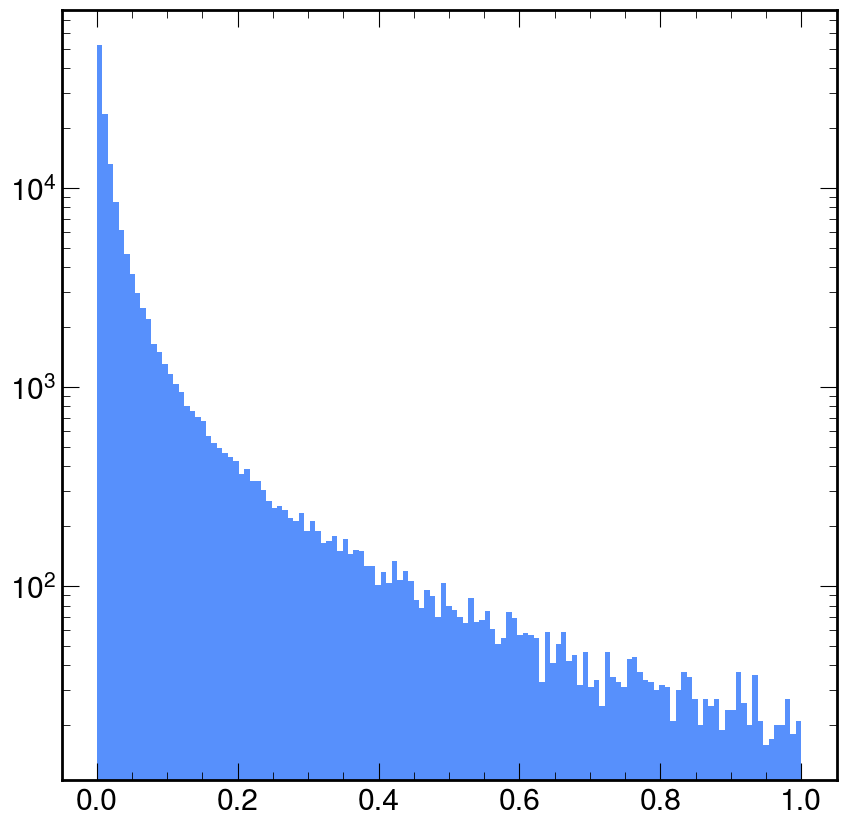

In [118]:
plt.hist(r, bins=bins)
plt.yscale('log')

In [67]:
x = np.median(data["gen_jet_tau_decay_vertex_x"])
y = np.median(data["gen_jet_tau_decay_vertex_y"])
z = np.median(data["gen_jet_tau_decay_vertex_z"])
print("x:", x)
print("y:", y)
print("z:", z)

x: -0.002925135252917904
y: -0.060735665686489276
z: -10.43471712417467


In [131]:
dv_d = np.sqrt(
    (data["gen_jet_tau_decay_vertex_x"]-data["reco_cand_PV_x"]) ** 2
    + (data["gen_jet_tau_decay_vertex_y"]-data["reco_cand_PV_y"]) ** 2
    + (data["gen_jet_tau_decay_vertex_z"]-data["reco_cand_PV_z"]) ** 2
)

In [132]:
dv_d

<Array [[20.6, 1.72e+03, ..., 1.72e+03], ...] type='9199 * var * float64'>

In [98]:
    tau_mask = data["gen_jet_tau_decaymode"] > 0
    data = data[tau_mask]
    gen_jet_tau_p4s = g.reinitialize_p4(data["gen_jet_full_tau_p4s"])
    gen_jet_tau_gamma = np.sqrt(1 + (gen_jet_tau_p4s.p / tau_mass) ** 2)
    # gen_jet_tau_gamma = 1 / np.sqrt(1 - (gen_jet_tau_p4s.p / tau_mass) ** 2)
    expected_traveldistance = gen_jet_tau_gamma * c * tau_lifetime

In [99]:
np.median(expected_traveldistance)

4.99660966190402

In [100]:

gen_lifetime = dv_d / (gen_jet_tau_gamma * c)

In [101]:
import math

[0.25, 0.266, 0.177, 0.112, 0.0678, ..., 0.000218, 0, 0.000109, 0.000109]


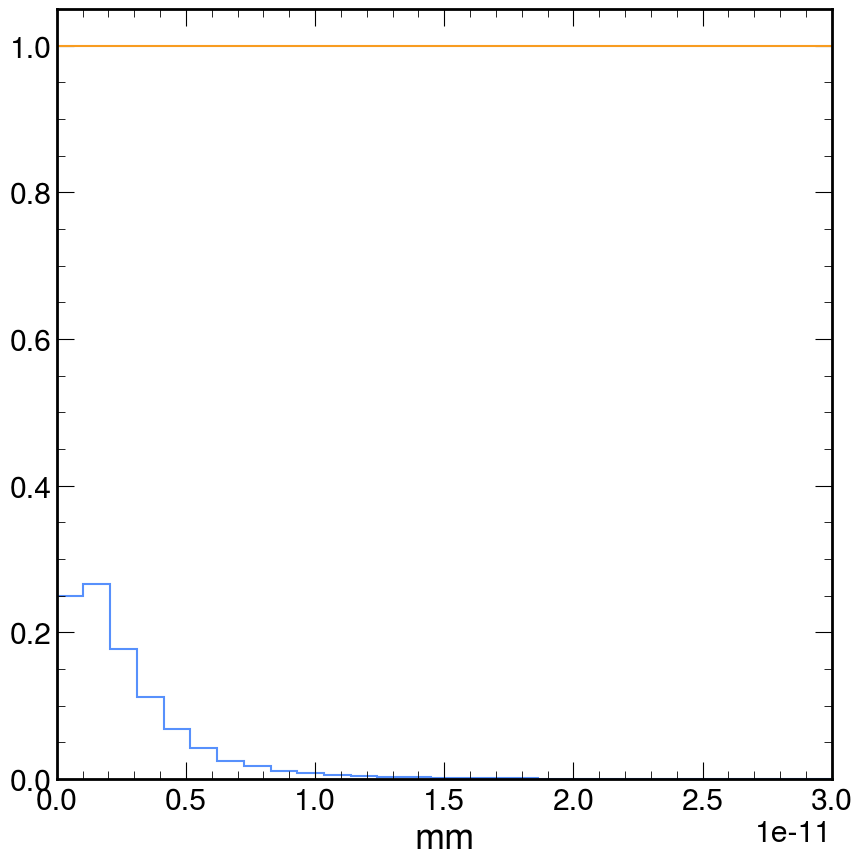

In [119]:
values = gen_lifetime
xmin = 0
xmax = 3e-11
fig, ax = plt.subplots()
rms = np.sqrt(ak.sum(values**2) * (1 / (len(values))))
bins = np.linspace(xmin, xmax, num=30)
hist, bin_edges = np.histogram(values, bins=bins)
hist = hist / ak.sum(hist)
hep.histplot(hist, bin_edges)
x = np.linspace(0,3e-11,30)
y = [(np.e**(-tau_lifetime*50)*(tau_lifetime*50)**v) / math.gamma(v+1) for v in x]
plt.plot(x,y)
plt.xlabel("mm", loc="center")

plt.xlim((xmin, xmax))
print(hist)

In [83]:
pt_zz = g.reinitialize_p4(data_zz["gen_jet_full_tau_p4s"]).pt
pt_zh = g.reinitialize_p4(data_zh["gen_jet_full_tau_p4s"]).pt

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f6a62391f30>, errorbar=None, legend_artist=None)]

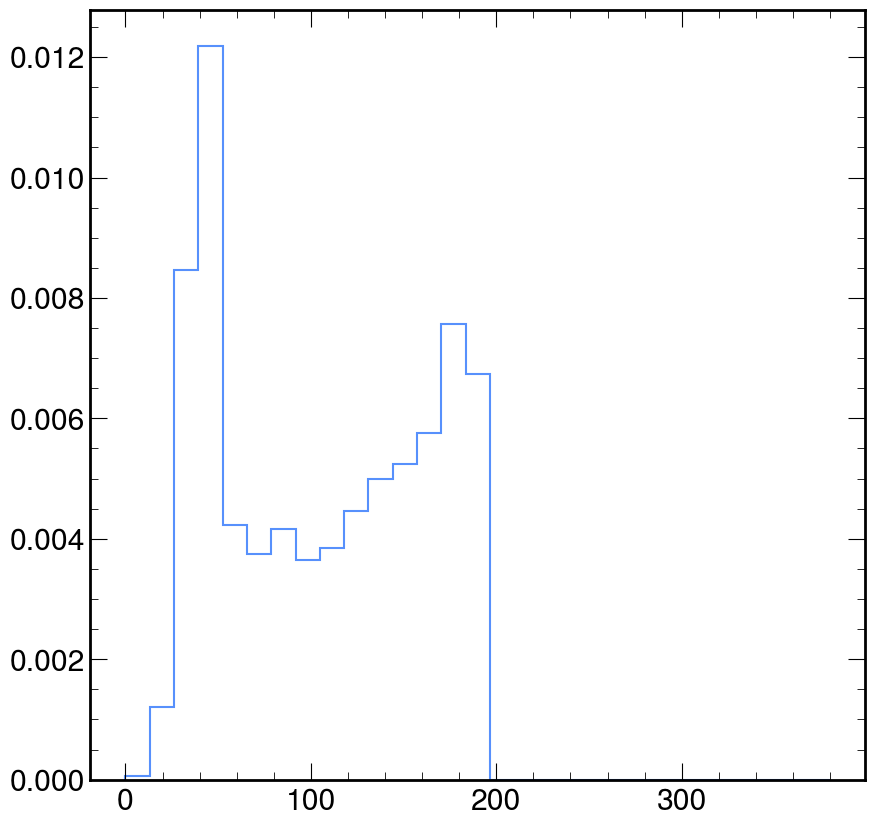

In [102]:
hist1, bin_edges = np.histogram(pt_zz, bins=bins)
hist1 = hist1 / ak.sum(hist1)
hep.histplot(hist1, bin_edges, density = True)

In [79]:
nr_events = len(pt_zh) + len(pt_zz)
print(nr_events)

19848


In [108]:
def plot_pt(values1, values2, label1, label2, xmin, xmax, nbins=30):
    fig, ax = plt.subplots()
    bins = np.linspace(xmin, xmax, num=30)
    hist1, bin_edges = np.histogram(values1, bins=bins)
    hist1 = hist1 / ak.sum(hist1)
    hep.histplot(hist1, bin_edges, density = True, label = label1)
    hist2, bin_edges = np.histogram(values2, bins=bins)
    hist2 = hist2 / ak.sum(hist2)
    hep.histplot(hist2, bin_edges, density = True, label = label2)
    plt.xlabel("GeV", loc="center")
    plt.xlim((xmin, xmax))
    plt.legend(loc="upper right")
    print("ZZ pT_mean: %s, ZZ pT_stdev: %s" %(
    round(np.mean(values1),2 ), round(np.std(values1), 2)
    ))
    print("ZH pT_mean: %s, ZH pT_stdev: %s" %(
    round(np.mean(values2),2 ), round(np.std(values2), 2)
    ))

ZZ pT_mean: 106.2, ZZ pT_stdev: 55.48
ZH pT_mean: 86.0, ZH pT_stdev: 38.55


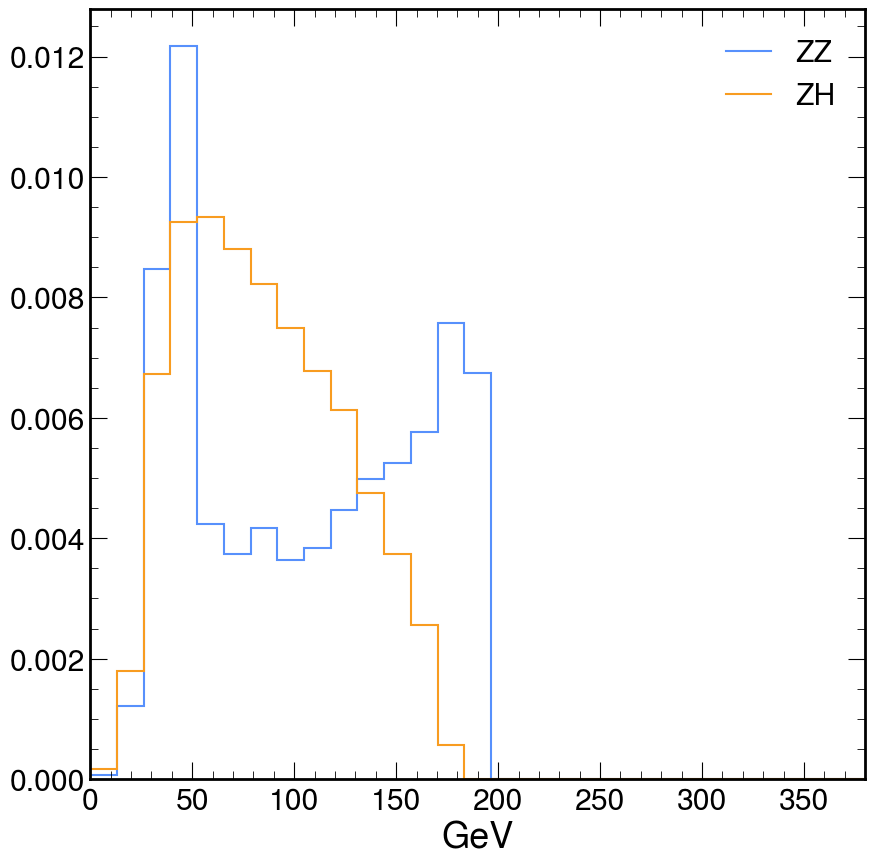

In [109]:
plot_pt(
    values1=ak.flatten(pt_zz, axis=-1),
    values2=ak.flatten(pt_zh, axis=-1),
    label1 = 'ZZ',
    label2 = 'ZH',
    xmin=0,
    xmax=380,
)

In [11]:
data_zz.fields

['event_reco_cand_p4s',
 'event_reco_cand_pdg',
 'event_reco_cand_charge',
 'reco_cand_p4s',
 'reco_cand_charge',
 'reco_cand_pdg',
 'reco_jet_p4s',
 'event_reco_cand_dxy',
 'event_reco_cand_dz',
 'event_reco_cand_d3',
 'event_reco_cand_dxy_f2D',
 'event_reco_cand_dz_f2D',
 'event_reco_cand_d3_f2D',
 'event_reco_cand_dxy_err',
 'event_reco_cand_dz_err',
 'event_reco_cand_d3_err',
 'event_reco_cand_dxy_f2D_err',
 'event_reco_cand_dz_f2D_err',
 'event_reco_cand_d3_f2D_err',
 'event_reco_cand_signed_dxy',
 'event_reco_cand_signed_dz',
 'event_reco_cand_signed_d3',
 'event_reco_cand_signed_dxy_f2D',
 'event_reco_cand_signed_dz_f2D',
 'event_reco_cand_signed_d3_f2D',
 'event_reco_cand_d0',
 'event_reco_cand_z0',
 'event_reco_cand_d0_err',
 'event_reco_cand_z0_err',
 'event_reco_cand_signed_d0',
 'event_reco_cand_signed_z0',
 'event_reco_cand_PCA_x',
 'event_reco_cand_PCA_y',
 'event_reco_cand_PCA_z',
 'event_reco_cand_PCA_x_err',
 'event_reco_cand_PCA_y_err',
 'event_reco_cand_PCA_z_err',
 

In [113]:
import pyhepmc

In [114]:
def load_events_from_hepmc(root_file_path: str):
    hepmc_file_path  = root_file_path.replace(".root", ".hepmc").replace("reco_", "sim_")
    events = []
    if not os.path.exists(hepmc_file_path):
        print(f"Incorrect path for the .hepmc file: {hepmc_file_path}")
    with pyhepmc.open(hepmc_file_path) as f:
        for event in f:
            events.append(event)
    return events

In [115]:
path = "/local/joosep/clic_edm4hep/2024_03/p8_ee_Z_Ztautau_ecm380/reco_p8_ee_Z_Ztautau_ecm380_400001.root"

In [116]:
ev = load_events_from_hepmc(path)

In [117]:
f = ev[0]

In [119]:
e = f.particles[0]

In [127]:
e.end_vertex.position[:3]

TypeError: __getitem__(): incompatible function arguments. The following argument types are supported:
    1. (self: pyhepmc._core.FourVector, arg0: int) -> float

Invoked with: FourVector(-0.129, -0.784, -19.8, 0.144), slice(None, 3, None)

In [128]:
data_zh_ = g.load_all_data( "/home/norman/tmp/ZH_Htautau", n_files=100)

[1/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_201846.parquet
[2/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_202302.parquet
[3/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_200157.parquet
[4/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_204225.parquet
[5/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_203058.parquet
[6/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_204781.parquet
[7/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_203397.parquet
[8/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_201510.parquet
[9/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_204043.parquet
[10/10] Loading from /home/norman/tmp/ZH_Htautau/reco_p8_ee_ZH_Htautau_ecm380_202493.parquet
Input data loaded


In [136]:
out = "/home/norman/newshit"
os.makedirs(out, exist_ok = True)

In [137]:
process_data(data_zh_, out)

/opt/conda/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/opt/conda/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/opt/conda/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/opt/conda/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


PCA_x <= 0.02 0.0005373455131649651
PCA_y <= 0.02 0.0021493820526598604
{
    "L_PCA_DV_diff": -17.301537424550617,
    "P_PCA_DV_diff_x": -5.471121530873167,
    "P_PCA_DV_diff_y": -0.1212710511112301,
    "L_PV_diff": -19.05390107183009,
    "P_PV_diff_x": 0.007983790525079758,
    "P_PV_diff_y": 0.17936951764144352
}
----------------------------------------------------
{
    "L_PCA_DV_diff": -17.343488250885066,
    "P_PCA_DV_diff_x": 5.13704947115647,
    "P_PCA_DV_diff_y": -0.7243487761915391,
    "L_PV_diff": -19.09585189816454,
    "P_PV_diff_x": -0.3157889621691623,
    "P_PV_diff_y": -0.10991172115548642
}
----------------------------------------------------
{
    "L_PCA_DV_diff": -17.32640237075338,
    "P_PCA_DV_diff_x": 0.7405772223479414,
    "P_PCA_DV_diff_y": 5.299797339812589,
    "L_PV_diff": -19.078766018032855,
    "P_PV_diff_x": 0.14303022879056615,
    "P_PV_diff_y": -0.1549178191159725
}
----------------------------------------------------
{
    "L_PCA_DV_diff": -